## Import Required Libraries

In [1]:
import json
import time
import os
import csv
import json
import numpy as np
import pandas as pd
import random
from itertools import combinations
import math
import sys
import pickle
%matplotlib inline
import matplotlib.pyplot as plt

## Load information about Playlist and Tracks

In [2]:
t0 = time.time()
# Load data matching playlist ID to Track ID
df_play_track = pd.read_csv('../data/track_w_playlist_id.csv')

# Convert PLaylist and Track IDs to numpy arrays
playlists = df_play_track['Playlist ID'].to_numpy()
songs = df_play_track['Track ID'].to_numpy()

# Load file containing the Track names
fr = open('../data/tracks_w_names.csv', 'r', encoding="utf-8")
reader = csv.reader(fr)
track_name = []
for row in reader:
    track_name.append(row[1])
fr.close()

In [3]:
# Load file containing candidate pair 
fr = open("../data/candidate_pair_1rows_10bands.pickle", "rb")
can_pairs = pickle.load(fr, encoding='bytes')
fr.close()

# Sort data to make it easier to search
can_pairs = can_pairs[can_pairs[:, 0].argsort()]

## Define Function to Recommend Tracks

In [4]:
def song_recommendation(playlist_track_ids, k, candidate_pairs, track_with_name):

    # Get all similar tracks using candidate pairs
    track_ids = np.array([], dtype=int)
    for i in playlist_track_ids:
        idx_start = np.searchsorted(candidate_pairs[:, 0], i, side='left')
        idx_end = np.searchsorted(candidate_pairs[:, 0], i, side='right')
        can_track_ids = candidate_pairs[np.array(range(idx_start,idx_end+1)),1]
        track_ids = np.append(track_ids, can_track_ids)
    
    # Get count of number of each recommended track
    track_rec_id_count = dict([])
    for track in track_ids:
        count = track_rec_id_count.get(track, 0)
        track_rec_id_count[track] = count + 1
    

    # Convert track dictionary to list for easier use
    track_vs_count = []
    for key, value in track_rec_id_count.items():
        track_vs_count.append([value, key])
    
    # Sort track recommendation by suggestion count
    track_vs_count.sort(reverse=True)
    track_vs_count = np.array(track_vs_count)
    
    # Return top K results
    final_ids = track_vs_count[0:k,1]
    track_names = []
    for ele in final_ids:
        track_names.append(track_with_name[ele])
    
    return track_names


## Produce Click Score for each Playlist

In [5]:
# Initialize variables for results
attempts = []
sz = []

# Loop through the 1,000,000 playlists
t0 = time.time()
for n in range(0,1000000):
    
    # Get list of tracks from a specific playlist
    idx_start = np.searchsorted(playlists, n, side='left')
    idx_end = np.searchsorted(playlists, n, side='right')
    
    # Check Clist score if playlist is at least 1 song long
    if idx_end - idx_start >= 1:           
        # Set initial values
        tries = []
        
        # Get number of input and test songs from playlist
        playlist_track_list = songs[idx_start:idx_end]
        num_input_songs = round(len(playlist_track_list)*0.75)
        num_test_songs = len(playlist_track_list)-num_input_songs  
        
        # Record playlist length
        sz.append(len(playlist_track_list))

        # Get random set of input songs
        random.shuffle(playlist_track_list)
        input_songs = list(playlist_track_list[0:num_input_songs])
        input_songs = [int(i) for i in input_songs]
        
        # Get random set of test songs
        test_songs = playlist_track_list[num_test_songs:num_input_songs+num_test_songs]
        
        # Get song recommendations
        recom_songs = song_recommendation(input_songs, 500, can_pairs, track_name)
        
        # Check if and when a test song appears in the recommendation
        # Loop through test songs
        for k in range(0,len(recom_songs)):
            
            # Loop through recommended songs
            for i in range(0, num_test_songs):
                
                # If recommended song is in test set, record song index
                if track_name[test_songs[i]] in recom_songs[k]:
                    tries.append(k+1)
        
        # Add results to list
        if len(tries) > 0:
            attempts.append((min(tries)-1)/10)
        else:
            attempts.append(51)
        
    # Display Results
    print('Elapsed Time:',time.time()-t0,'Playlist:',n, 'Click Score:', attempts[-1], 'Playlist length:', num_input_songs+num_test_songs)

Elapsed Time: 0.12335991859436035 Playlist: 0 Click Score: 1.1 Playlist length: 51
Elapsed Time: 0.6672611236572266 Playlist: 1 Click Score: 2.2 Playlist length: 39
Elapsed Time: 0.7181868553161621 Playlist: 2 Click Score: 0.8 Playlist length: 64
Elapsed Time: 0.8835811614990234 Playlist: 3 Click Score: 0.7 Playlist length: 126
Elapsed Time: 0.9185855388641357 Playlist: 4 Click Score: 15.2 Playlist length: 17
Elapsed Time: 1.0237390995025635 Playlist: 5 Click Score: 0.8 Playlist length: 75
Elapsed Time: 1.0393669605255127 Playlist: 6 Click Score: 51 Playlist length: 16
Elapsed Time: 1.1534407138824463 Playlist: 7 Click Score: 0.5 Playlist length: 52
Elapsed Time: 1.2276263236999512 Playlist: 8 Click Score: 18.7 Playlist length: 46
Elapsed Time: 1.2586908340454102 Playlist: 9 Click Score: 51 Playlist length: 20
Elapsed Time: 1.4180271625518799 Playlist: 10 Click Score: 8.8 Playlist length: 72
Elapsed Time: 1.6580266952514648 Playlist: 11 Click Score: 14.0 Playlist length: 130
Elapsed Ti

KeyboardInterrupt: 

In [61]:
# Save results for later use
fw = open('../data/clicks_score.csv', 'w', newline='')
writer = csv.writer(fw, delimiter=',')
writer.writerow(attempts)
writer.writerow(sz)
fw.close()

## Plot Results

In [7]:
# Load click score data
fr = open('../data/clicks_score.csv', 'r', encoding="utf-8")
reader = csv.reader(fr)
clicks = []
for row in reader:
    clicks.append(row)
fr.close()

# Extract data from loaded data
click_score = np.empty([len(clicks[0]),1])
playlist_size = np.empty([len(clicks[0]),1])
for i in range(0,len(clicks[0])):
    click_score[i] = float(clicks[0][i])
    playlist_size[i] = float(clicks[1][i])
    
# Get Mean Clicks based on minimum playlist size
mean_clicks = []

# Loop through each minimum length
for n in range(0, 250):
    
    # Initialize click score for min playlist length
    single_click_set = []
    
    # Loop thgouh each playlist
    for i in range(0,len(playlist_size)):
        
        # If playlist longer than min, save data
        if playlist_size[i] >= n:
            single_click_set.append(click_score[i])
            
    # Add mean to data structure
    mean_clicks.append(np.mean(single_click_set))

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


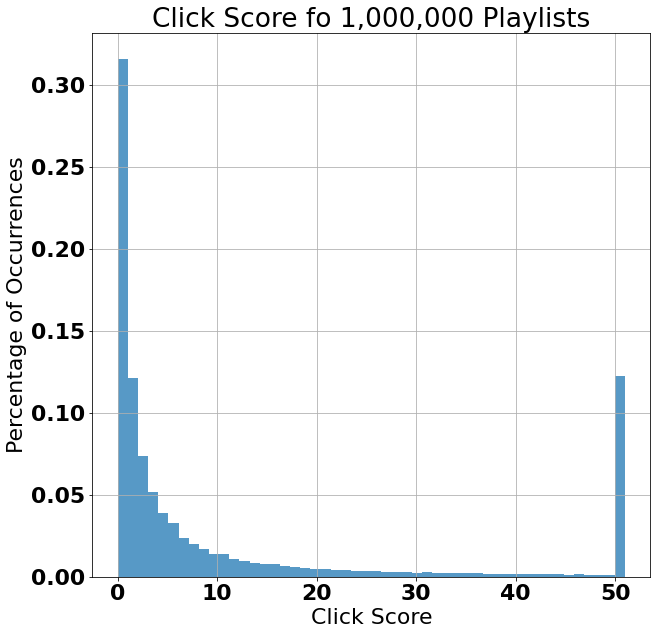

In [8]:
# Format Plot Text
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

# Plot Error vs Epoch number for various learning rates
plt.figure(figsize=(10,10))
plt.hist(click_score, 50, density=True, alpha=0.75)
plt.title('Click Score fo 1,000,000 Playlists')
plt.xlabel('Click Score')
plt.ylabel('Percentage of Occurrences')
plt.grid()

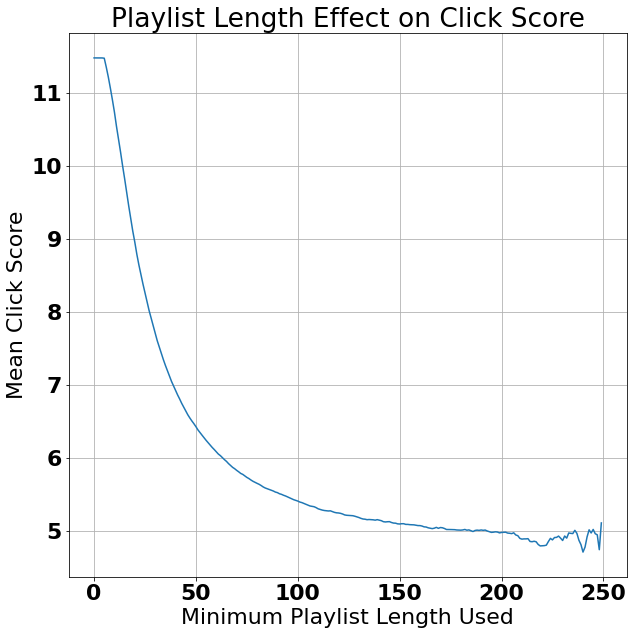

In [9]:
plt.figure(figsize=(10,10))
plt.plot(np.array(range(0, 250)),mean_clicks)
plt.title('Playlist Length Effect on Click Score')
plt.xlabel('Minimum Playlist Length Used')
plt.ylabel('Mean Click Score')
plt.grid()